In [71]:
from netCDF4 import Dataset
import numpy as np
import os
import datetime
import pickle
import xarray as xr
from regrid import regrid
import matplotlib.pyplot as plt
import tqdm
from scipy.stats import pearsonr

In [4]:
d = Dataset('WG_SM_2019.nc')
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    time: days since Jan 1st 1970
    dimensions(sizes): t(145), x(361), y(361)
    variables(dimensions): float64 WG(t,x,y), float32 SM(t,x,y), int32 IT(t,x,y), float64 mask(x,y), float32 lon(x,y), float32 lat(x,y), int64 dt(t)
    groups: 

In [11]:
dates = [datetime.date(1970,1,1)+datetime.timedelta(days=np.int(days)) for days in np.array(d['dt'])]

mask = np.array(d['mask'])

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: ht

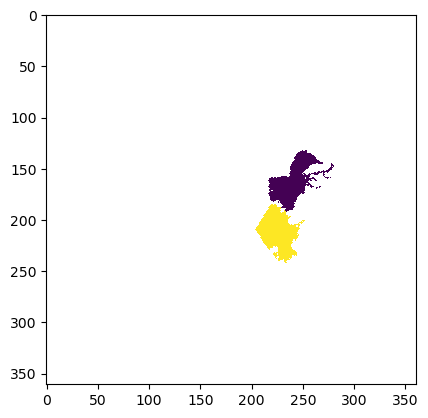

In [248]:
m = mask.copy()

regs = [2,8,9,10,11,12,13,15]
regs = [9,10]
# regs = [12,13]

m[~np.isin(mask, regs)] = np.nan

plt.imshow(m)

plt.show()

In [228]:
import warnings
warnings.filterwarnings("ignore")

def mask_data(regs,FYI_only=False):


    FYI_SM_mean = []
    FYI_WG_mean = []


    for i in range(len(d['dt'])):

        SM = np.array(d['SM'][i])
        WG = np.array(d['WG'][i])
        IT = np.array(d['IT'][i]).astype(np.float32)


        SM[~np.isin(mask, regs)] = np.nan
        WG[~np.isin(mask, regs)] = np.nan
        
        if FYI_only:
            SM[IT!=2] = np.nan
            WG[IT!=2] = np.nan

        FYI_SM_mean.append(np.nanmean(SM))
        FYI_WG_mean.append(np.nanmean(WG))

    return(FYI_SM_mean, FYI_WG_mean)

<Figure size 640x480 with 0 Axes>

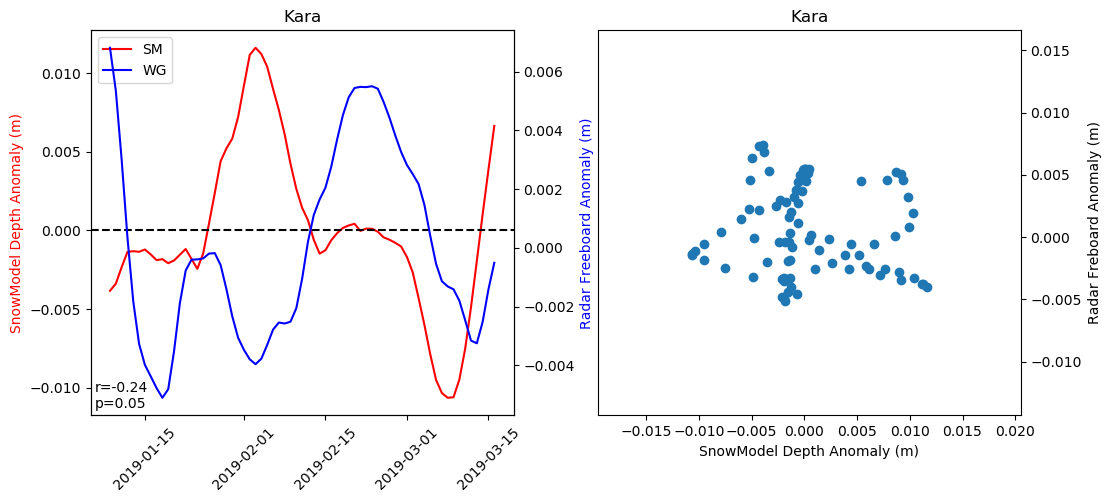

<Figure size 640x480 with 0 Axes>

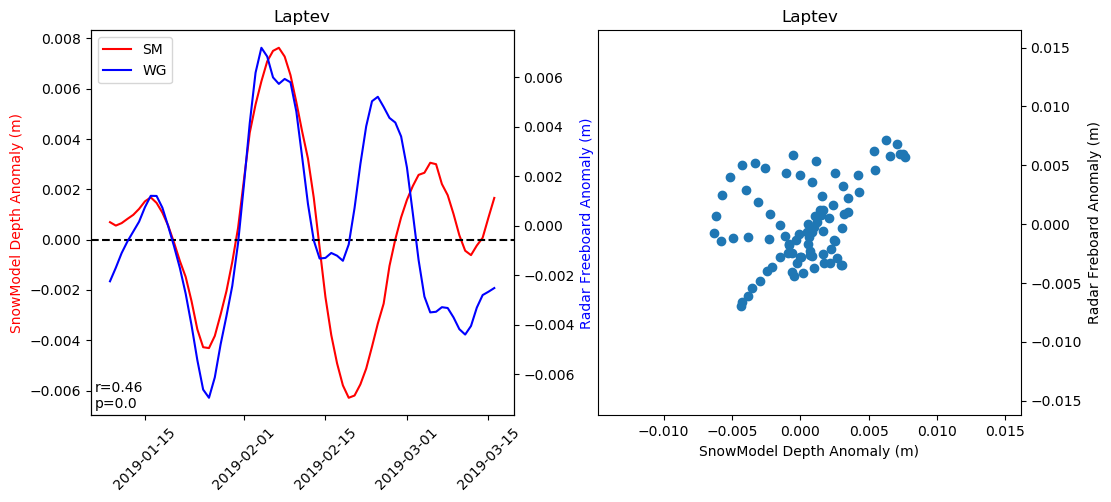

<Figure size 640x480 with 0 Axes>

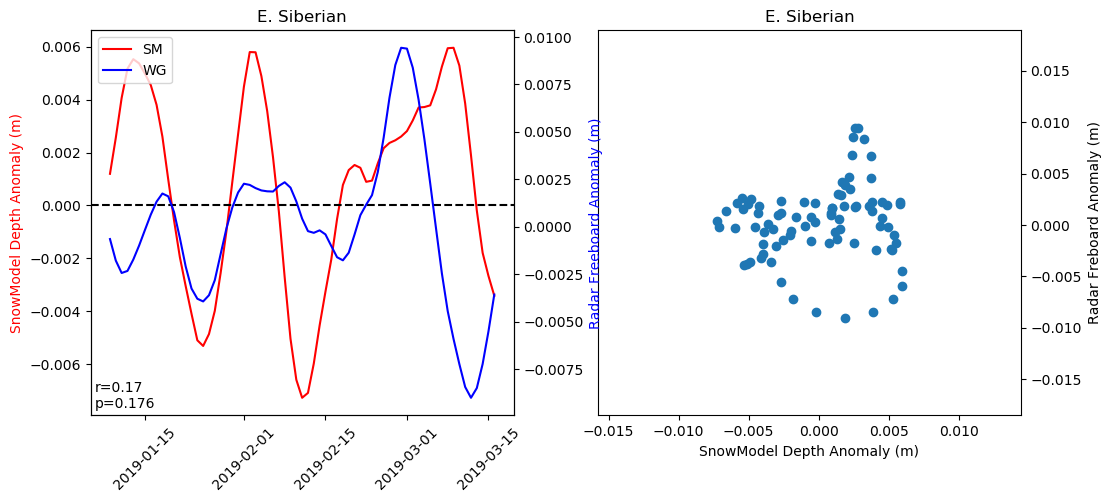

<Figure size 640x480 with 0 Axes>

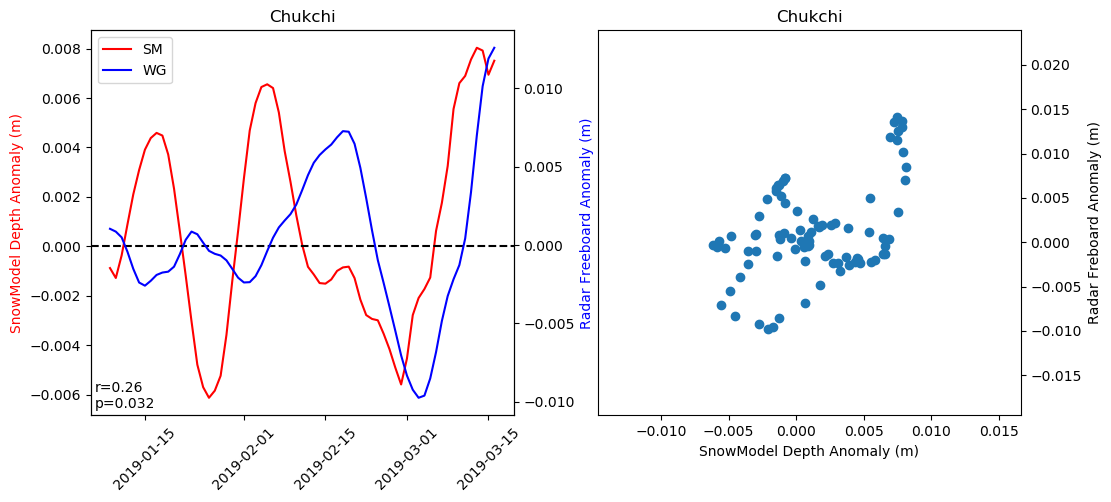

<Figure size 640x480 with 0 Axes>

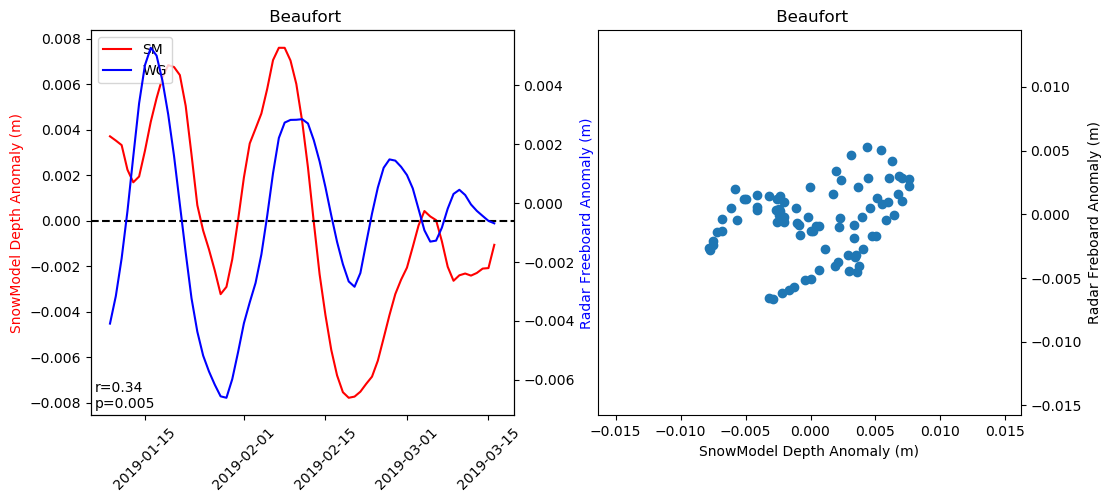

<Figure size 640x480 with 0 Axes>

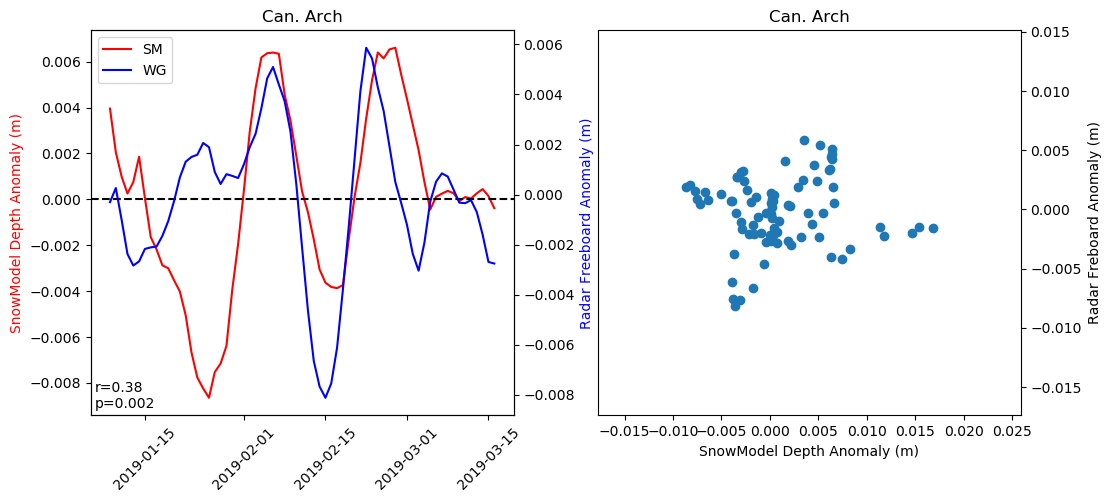

<Figure size 640x480 with 0 Axes>

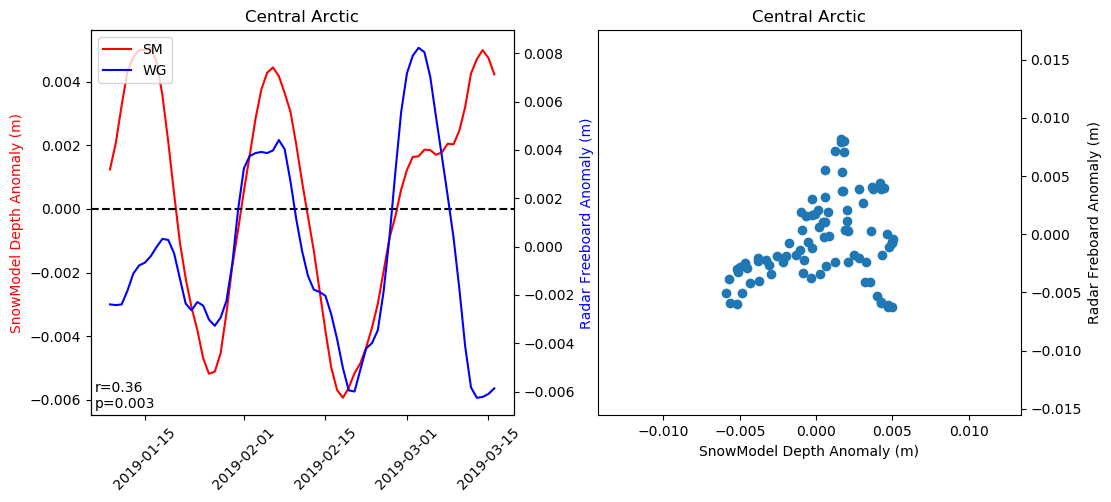

<Figure size 640x480 with 0 Axes>

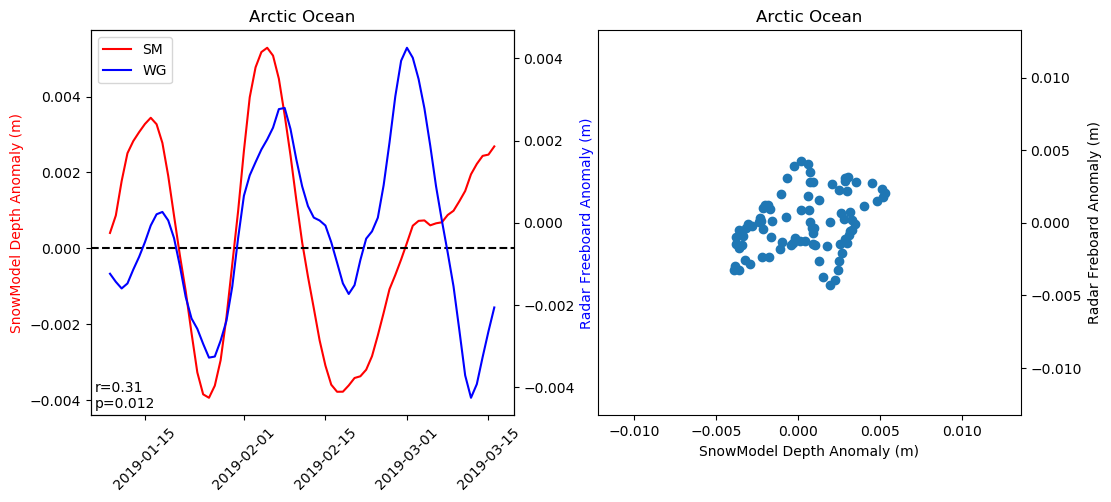

In [255]:
rm1 = 30
rm2 = 9


for regs, reg_name in zip([[9], [10], [11], [12], [13], [14], [15], [9,10,11,12,13,15]], 
                          ['Kara', 'Laptev', 'E. Siberian', 'Chukchi',' Beaufort', 'Can. Arch', 'Central Arctic', 'Arctic Ocean']):


    FYI_SM_mean, FYI_WG_mean = mask_data(regs=regs, FYI_only=False)

    SM_smooth = np.convolve(FYI_SM_mean, np.ones(rm1)/rm1,mode='same')
    WG_smooth = np.convolve(FYI_WG_mean, np.ones(rm1)/rm1,mode='same')

    SM_anom = np.convolve(FYI_SM_mean - SM_smooth, np.ones(rm2)/rm2,mode='same')
    WG_anom = np.convolve(FYI_WG_mean - WG_smooth, np.ones(rm2)/rm2,mode='same')

    plt.figure()

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

    ax1.plot(dates[(rm1+rm2):-(rm1+rm2)],
            SM_anom[(rm1+rm2):-(rm1+rm2)],
            label='SM',color='r')

    ax1.plot([dates[40]],[0],color='b',label='WG')

    ax1.set_ylabel('SnowModel Depth Anomaly (m)',color='r')


    rstats = pearsonr(SM_anom[(rm1+rm2):-(rm1+rm2)],
                      WG_anom[(rm1+rm2):-(rm1+rm2)],
                     )

    r = np.round(rstats[0],decimals=2)
    p = np.round(rstats[1],decimals=3)

    ax1.annotate(f'r={r}\np={p}',xy=(0.01,0.01),
                 va='bottom',ha='left',xycoords='axes fraction')

    ax1.set_xticklabels(ax.get_xticks(),rotation=45)

    ax1b = ax1.twinx()

    ax1b.set_ylabel('Radar Freeboard Anomaly (m)',color='b')

    ax1b.plot(dates[(rm1+rm2):-(rm1+rm2)],
             WG_anom[(rm1+rm2):-(rm1+rm2)],
             label='WG',color='b')

    ax1.legend(loc='upper left')

    ax1.axhline(0,color='k',ls='--')


    ax2.scatter(SM_anom[rm1+0:-rm1+0],
                      WG_anom[rm1:-rm1])

    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')

    ax2.set_xlabel('SnowModel Depth Anomaly (m)')
    ax2.set_ylabel('Radar Freboard Anomaly (m)')
    
    ax1.set_title(reg_name)
    ax2.set_title(reg_name)

    plt.show()

<Figure size 640x480 with 0 Axes>

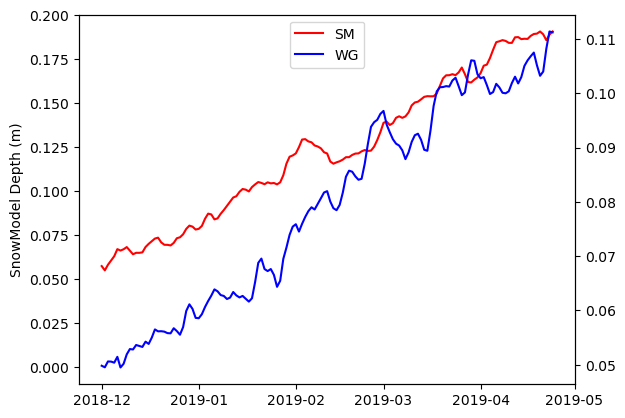

In [105]:
plt.figure()

fig, ax = plt.subplots(1,1)

ax.plot(dates,FYI_SM_mean,label='SM',color='r')
ax.plot([dates[0]],[0],color='b',label='WG')
ax.set_ylabel('SnowModel Depth (m)')
ax2.set_ylabel('Radar Freeboard (m)')

ax2 = ax.twinx()

ax2.plot(dates,FYI_WG_mean,label='WG',color='b')

ax.legend(loc='upper center')

plt.show()